--- Starting Data Analysis ---

--- Analysis Complete: Processed 20 simulation runs. ---


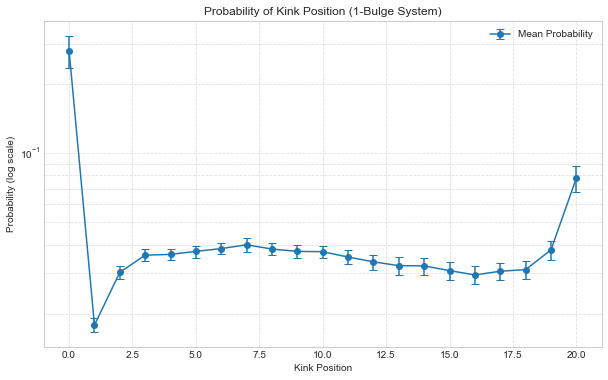

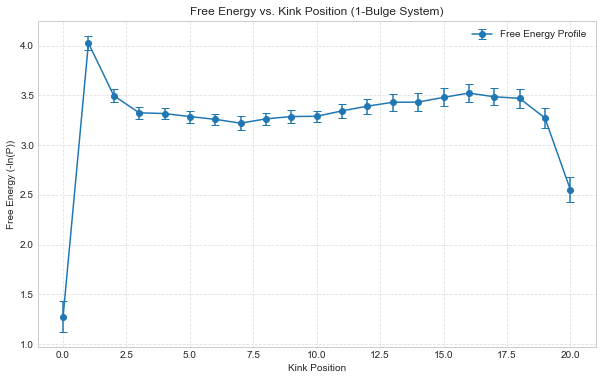

Final probability data saved to: 4strand_1bulge_prob_python.csv


In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt

def analyze_simulation_data(base_dir="data", num_sims=20, max_len=23):
    """
    Reads and analyzes simulation data from 'energy.dat' files, replicating
    the logic from the provided Mathematica script.

    This function performs the following steps:
    1.  Reads 'energy.dat' files from specified subdirectories.
    2.  For each simulation run, it calculates a 2D weighted histogram ('tot')
        of two order parameters (OP1 and OP2).
    3.  Projects the histogram onto the OP2 axis to get a 1D distribution.
    4.  Normalizes the distribution to get a probability curve.
    5.  Aggregates results from all simulation runs to calculate mean and
        standard error.
    6.  Generates and displays two plots:
        - Probability vs. Kink Position (log scale)
        - Free Energy (-ln(Probability)) vs. Kink Position
    7.  Saves the final probability data to a CSV file.

    Args:
        base_dir (str): The main directory containing the simulation folders.
        num_sims (int): The number of different simulation seeds (e.g., 20).
        max_len (int): The maximum dimension for the order parameter arrays.
    """
    # Define the names of the simulation folders to process
    folders = [
        "diff_w1", "diff_w1x", "diff_w1x3", "diff_w1x4",
        "diff_w1x5", "diff_w1x6", "diff_w1x7", "diff_w1x8"
    ]

    print("--- Starting Data Analysis ---")
    all_op_distributions = []

    # Loop over each simulation seed (from 1 to num_sims)
    for q in range(1, num_sims + 1):
        # Initialize a 2D array to store the weighted counts of OP1 vs OP2
        # This is equivalent to the 'tot' array in Mathematica
        tot = np.zeros((max_len, max_len))
        
        # Loop through each of the specified folders for the current seed
        for folder_name in folders:
            # Construct the path to the energy.dat file
            file_path = os.path.join(base_dir, folder_name, f"d_{q}", "energy.dat")

            try:
                # Read the data file.
                # We need columns 6, 7, 9, 10 from Mathematica (0-indexed: 5, 6, 8, 9)
                datax = np.loadtxt(file_path, usecols=(5, 6, 8, 9))

                # Process each row in the loaded data
                for row in datax:
                    # CORRECTION HERE:
                    # Mathematica used the 2nd and 3rd extracted columns for indices.
                    # In our 0-indexed 'row' array, these correspond to indices 1 and 2.
                    op1 = int(row[1]) # Original column 7
                    op2 = int(row[2]) # Original column 9
                    weight = 1.0 / row[3] # Original column 10

                    # Check if indices are within the bounds of the 'tot' array
                    if 0 <= op1 < max_len and 0 <= op2 < max_len:
                        # Add the weight to the corresponding bin in the 2D histogram
                        tot[op1, op2] += weight

            except FileNotFoundError:
                print(f"Warning: File not found and will be skipped: {file_path}")
            except Exception as e:
                print(f"An error occurred while processing {file_path}: {e}")
        
        # Now, process the 'tot' matrix for the current simulation run 'q'
        if np.sum(tot) == 0:
            print(f"Warning: No data processed for simulation {q}. Skipping.")
            continue
            
        # Sum the 'tot' matrix along the columns (axis=0) to project onto the OP2 axis.
        # This gives the distribution of OP2, equivalent to 'op1' in the Mathematica script.
        op_distribution = np.sum(tot, axis=0)

        # Calculate the total sum for normalization
        total_sum = np.sum(tot)
        
        # Trim the last two elements, as done in the Mathematica script
        op_distribution_trimmed = op_distribution[:-2]
        
        # Normalize the distribution to get probabilities
        op_normalized = op_distribution_trimmed / total_sum
        
        # Append the final probability distribution for this run to our list
        all_op_distributions.append(op_normalized)

    if not all_op_distributions:
        print("\nError: No data was successfully processed. Exiting.")
        return

    print(f"\n--- Analysis Complete: Processed {len(all_op_distributions)} simulation runs. ---")

    # --- Final Statistics and Plotting ---
    
    # Convert the list of distributions into a 2D NumPy array for easy calculation
    op_array = np.array(all_op_distributions)

    # Calculate the mean probability across all simulations for each position
    prob_mean = np.mean(op_array, axis=0)
    
    # Calculate the sample standard deviation (ddof=1 for sample vs population)
    prob_std = np.std(op_array, axis=0, ddof=1)
    
    # Calculate the standard error of the mean (SEM)
    prob_sem = prob_std / np.sqrt(len(all_op_distributions))
    
    # Create an array for the x-axis (kink position)
    x_positions = np.arange(len(prob_mean))

    # --- Plot 1: Probability vs. Kink Position ---
    plt.figure(figsize=(10, 6))
    plt.errorbar(x_positions, prob_mean, yerr=prob_sem, fmt='-o', capsize=4, label='Mean Probability')
    plt.yscale('log')
    plt.title('Probability of Kink Position (1-Bulge System)')
    plt.xlabel('Kink Position')
    plt.ylabel('Probability (log scale)')
    plt.grid(True, which="both", ls="--", alpha=0.6)
    plt.legend()
    plt.show()

    # --- Plot 2: Free Energy vs. Kink Position ---
    # Free Energy is proportional to -ln(P)
    free_energy = -np.log(prob_mean)
    # Propagate the error: error_ln(P) = error(P) / P
    free_energy_error = prob_sem / prob_mean
    
    plt.figure(figsize=(10, 6))
    plt.errorbar(x_positions, free_energy, yerr=free_energy_error, fmt='-o', capsize=4, label='Free Energy Profile')
    plt.title('Free Energy vs. Kink Position (1-Bulge System)')
    plt.xlabel('Kink Position')
    plt.ylabel('Free Energy (-ln(P))')
    plt.grid(True, which="both", ls="--", alpha=0.6)
    plt.legend()
    plt.show()

    # --- Export Data ---
    output_filename = "4strand_1bulge_prob_python.csv"
    output_data = np.column_stack((x_positions, prob_mean, prob_sem))
    np.savetxt(
        output_filename,
        output_data,
        delimiter=',',
        header='Kink_Position,Mean_Probability,Standard_Error',
        fmt='%f'
    )
    print(f"Final probability data saved to: {output_filename}")


if __name__ == '__main__':
    # Set the base directory relative to where the script is run.
    # Assumes a folder named 'data' is in the same directory as the script.
    data_directory = "data"
    analyze_simulation_data(base_dir=data_directory)

In [28]:
import os
import numpy as np
import time

# --- Global Parameters ---
# These can be adjusted as needed.
NUM_SIMS = 20
BASE_DATA_DIR = "data"
# Subdirectory for pre-processed data
OUTPUT_DIR = "wham_analysis_output"

def read_and_preprocess_data():
    """
    Reads energy.dat files from different simulation windows,
    flattens the data for each simulation run, and saves the results
    as NumPy arrays (.npy files).

    This script prepares the raw simulation output for the main
    WHAM analysis script.
    """
    print("--- Part 1: Reading and Pre-processing Data ---")

    # Define the folder lists for the three simulation windows
    # Window 1: Middle region
    folders1 = ["diff_w3_middle_noendx2", "diff_w3_middle_noendx3", "diff_w3_middle_noendx4"]
    # Window 2: Start region
    folders2 = ["diff_w3_startov", "diff_w3_startovx2", "diff_w3_startovx3"]
    # Window 3: End region
    folders3 = ["diff_w3_endov", "diff_w3_endovx", "diff_w3_endovx2", "diff_w3_endovx3"]
    
    folder_groups = [folders1, folders2, folders3]
    # Define output names for the pre-processed data
    output_names = [
        "preprocessed_data_window1.npy",
        "preprocessed_data_window2.npy",
        "preprocessed_data_window3.npy"
    ]

    # Create the output directory if it doesn't exist
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # Process each window (start, middle, end)
    for i, folders in enumerate(folder_groups):
        all_sim_data_for_window = []
        print(f"\nProcessing Window {i+1}...")
        
        # Loop over each simulation seed (e.g., d_1, d_2, ... d_20)
        for sim_idx in range(1, NUM_SIMS + 1):
            start_time = time.time()
            data_for_current_sim = []
            
            # Loop through all the folders belonging to the current window
            for folder_name in folders:
                file_path = os.path.join(BASE_DATA_DIR, folder_name, f"d_{sim_idx}", "energy.dat")
                
                try:
                    # Read the last 5 columns (0-indexed: 5, 6, 7, 8, 9)
                    data = np.loadtxt(file_path, usecols=(5, 6, 7, 8, 9))
                    # Handle case where file has only one line of data
                    if data.ndim == 1:
                        data = data.reshape(1, -1)
                    if data.size > 0:
                        data_for_current_sim.append(data)
                except (FileNotFoundError, ValueError) as e:
                    print(f"Warning: Could not read or find {file_path}. Skipping. Error: {e}")
            
            # After reading all folder parts for one sim, flatten into one array
            if data_for_current_sim:
                all_sim_data_for_window.append(np.vstack(data_for_current_sim))
            
            end_time = time.time()
            print(f"  Sim {sim_idx:2d} (Window {i+1}) | Time: {end_time - start_time:.4f}s")
        
        # Save the collected data for this window to a .npy file
        # The resulting .npy file contains a list of NumPy arrays, one for each sim run
        output_path = os.path.join(OUTPUT_DIR, output_names[i])
        np.save(output_path, np.array(all_sim_data_for_window, dtype=object), allow_pickle=True)
        print(f"-> Successfully saved pre-processed data for window {i+1} to {output_path}")

if __name__ == '__main__':
    # Run the pre-processing function
    read_and_preprocess_data()
    print("\n--- Data Pre-processing Complete ---")


--- Part 1: Reading and Pre-processing Data ---

Processing Window 1...
  Sim  1 (Window 1) | Time: 0.3037s
  Sim  2 (Window 1) | Time: 0.2422s
  Sim  3 (Window 1) | Time: 0.2680s
  Sim  4 (Window 1) | Time: 0.1948s
  Sim  5 (Window 1) | Time: 0.2481s
  Sim  6 (Window 1) | Time: 0.1825s
  Sim  7 (Window 1) | Time: 0.2622s
  Sim  8 (Window 1) | Time: 0.2746s
  Sim  9 (Window 1) | Time: 0.2174s
  Sim 10 (Window 1) | Time: 0.2568s
  Sim 11 (Window 1) | Time: 0.2506s
  Sim 12 (Window 1) | Time: 0.2752s
  Sim 13 (Window 1) | Time: 0.2683s
  Sim 14 (Window 1) | Time: 0.3740s
  Sim 15 (Window 1) | Time: 0.3355s
  Sim 16 (Window 1) | Time: 0.2481s
  Sim 17 (Window 1) | Time: 0.2472s
  Sim 18 (Window 1) | Time: 0.2467s
  Sim 19 (Window 1) | Time: 0.2927s
  Sim 20 (Window 1) | Time: 0.2599s
-> Successfully saved pre-processed data for window 1 to wham_analysis_output/preprocessed_data_window1.npy

Processing Window 2...
  Sim  1 (Window 2) | Time: 0.2653s
  Sim  2 (Window 2) | Time: 0.2643s
  Si

--- Part 2: Performing WHAM Analysis with Statistical Error ---

Processing each of the 20 simulation runs independently...
  Processing Run 1/20...
  Processing Run 2/20...
  Processing Run 3/20...
  Processing Run 4/20...
  Processing Run 5/20...
  Processing Run 6/20...
  Processing Run 7/20...
  Processing Run 8/20...
  Processing Run 9/20...
  Processing Run 10/20...
  Processing Run 11/20...
  Processing Run 12/20...
  Processing Run 13/20...
  Processing Run 14/20...
  Processing Run 15/20...
  Processing Run 16/20...
  Processing Run 17/20...
  Processing Run 18/20...
  Processing Run 19/20...
  Processing Run 20/20...

--- Calculating final statistics from all runs ---


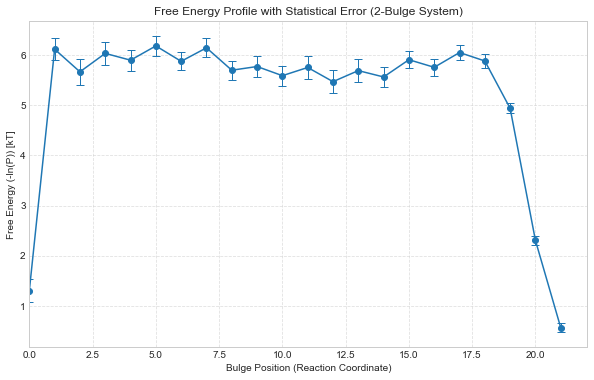

Final results with statistical error saved to: wham_analysis_output/4strand_2bulge_prob_python_with_error.csv


In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt

# --- Global Parameters ---
# These must match the parameters used in the pre-processing script.
NUM_SIMS = 20
BASE_DATA_DIR = "data"
OUTPUT_DIR = "wham_analysis_output"

# Maximum dimensions for the 4 order parameters (OPs)
DIMS = (35, 22, 22, 2)

def perform_wham_analysis_with_error():
    """
    Loads pre-processed data for 20 independent simulation runs.
    Performs a full WHAM analysis on each run to obtain 20 probability profiles.
    Calculates the mean and standard error of the mean (SEM) from these profiles.
    Plots the final free energy profile with statistically meaningful error bars.
    """
    print("--- Part 2: Performing WHAM Analysis with Statistical Error ---")
    
    # --- Load All Data ---
    try:
        data1_all_runs = np.load(os.path.join(OUTPUT_DIR, "preprocessed_data_window1.npy"), allow_pickle=True)
        data2_all_runs = np.load(os.path.join(OUTPUT_DIR, "preprocessed_data_window2.npy"), allow_pickle=True)
        data3_all_runs = np.load(os.path.join(OUTPUT_DIR, "preprocessed_data_window3.npy"), allow_pickle=True)

        weight_dir = os.path.join(BASE_DATA_DIR, '4strand_2kink')
        weights1_raw = np.loadtxt(os.path.join(weight_dir, "wfile_middle_noend.txt"))
        weights2_raw = np.loadtxt(os.path.join(weight_dir, "wfile_startov.txt"))
        weights3_raw = np.loadtxt(os.path.join(weight_dir, "wfile_endov.txt"))
    except FileNotFoundError as e:
        print(f"Error: Could not find required data or weight file. {e}")
        return

    # --- Prepare Weight Arrays (once, as they are shared) ---
    w1, w2, w3 = np.zeros(DIMS), np.zeros(DIMS), np.zeros(DIMS)
    for w_raw, w_target in [(weights1_raw, w1), (weights2_raw, w2), (weights3_raw, w3)]:
        for row in w_raw:
            idx = tuple(row[:4].astype(int))
            if all(d < DIMS[i] for i, d in enumerate(idx)):
                w_target[idx] = row[4]

    # --- Loop Through Each Simulation to Get 20 Profiles ---
    all_final_prob_profiles = []
    print("\nProcessing each of the 20 simulation runs independently...")

    for sim_idx in range(NUM_SIMS):
        print(f"  Processing Run {sim_idx + 1}/{NUM_SIMS}...")
        
        # Get data for the current simulation run
        data1 = data1_all_runs[sim_idx]
        data2 = data2_all_runs[sim_idx]
        data3 = data3_all_runs[sim_idx]

        # Skip run if any window is missing data
        if data1 is None or data2 is None or data3 is None:
            print(f"    Skipping run {sim_idx + 1} due to missing data.")
            continue
            
        # Number of data points for this run
        s1, s2, s3 = len(data1), len(data2), len(data3)

        # Create histograms for this run only
        aa1, aa2, aa3 = np.zeros(DIMS), np.zeros(DIMS), np.zeros(DIMS)
        for data_list, aa_target in [(data1, aa1), (data2, aa2), (data3, aa3)]:
            for row in data_list:
                idx = tuple(row[:4].astype(int))
                if all(d < DIMS[i] for i, d in enumerate(idx)):
                    aa_target[idx] += 1
        
        # --- WHAM Iterations for this specific run ---
        F = np.array([1.0, 1.0, 1.0])
        for i in range(100): # More iterations for convergence
            numerator = aa1 + aa2 + aa3
            denominator = (s1 * F[0] * w1) + (s2 * F[1] * w2) + (s3 * F[2] * w3)
            ub = numerator / (denominator + 1e-12) # Use smaller epsilon

            S1 = np.sum(w1 * ub)
            S2 = np.sum(w2 * ub)
            S3 = np.sum(w3 * ub)
            F_new = np.array([1/(S1 + 1e-12), 1/(S2 + 1e-12), 1/(S3 + 1e-12)])
            
            # Check for convergence
            if np.allclose(F, F_new, rtol=1e-6):
                F = F_new
                break
            F = F_new
            
        # --- Calculate final probability profile for this run ---
        op1_index = 34  # Corresponds to 35 in Mathematica
        ub_slice = ub[op1_index, :, :, :]
        count = np.sum(ub_slice, axis=(0, 2))
        
        total_prob = np.sum(count)
        if total_prob > 0:
            prob_dist = count / total_prob
            all_final_prob_profiles.append(prob_dist)

    # --- Calculate Mean and Standard Error from all profiles ---
    if not all_final_prob_profiles:
        print("Error: No simulation runs were successfully processed.")
        return

    print("\n--- Calculating final statistics from all runs ---")
    prob_array = np.array(all_final_prob_profiles)
    
    mean_prob = np.mean(prob_array, axis=0)
    # Use ddof=1 for sample standard deviation
    std_dev_prob = np.std(prob_array, axis=0, ddof=1) 
    # Standard Error of the Mean (SEM)
    sem_prob = std_dev_prob / np.sqrt(len(all_final_prob_profiles))

    # --- Calculate Final Free Energy and Propagate Error ---
    # To avoid log(0), replace zeros in mean_prob with a very small number
    mean_prob[mean_prob == 0] = 1e-12 
    free_energy = -np.log(mean_prob)
    # Error propagation: error(-ln(P)) = error(P) / P
    free_energy_error = sem_prob / mean_prob

    # --- Plotting ---
    plt.figure(figsize=(10, 6))
    x_positions = np.arange(len(mean_prob))
    plt.errorbar(x_positions, free_energy, yerr=free_energy_error, fmt='-o', capsize=4, color='C0', elinewidth=1, markeredgewidth=1)
    plt.title('Free Energy Profile with Statistical Error (2-Bulge System)')
    plt.xlabel('Bulge Position (Reaction Coordinate)')
    plt.ylabel('Free Energy (-ln(P)) [kT]')
    plt.grid(True, which="both", ls="--", alpha=0.6)
    plt.xlim(left=0)
    plt.show()

    # --- Save Final Results ---
    final_output_path = os.path.join(OUTPUT_DIR, "4strand_2bulge_prob_python_with_error.csv")
    final_data = np.column_stack((x_positions, mean_prob, sem_prob, free_energy, free_energy_error))
    np.savetxt(
        final_output_path,
        final_data,
        delimiter=',',
        header='Position,Mean_Probability,SEM_Probability,Free_Energy,SEM_Free_Energy',
        fmt='%e' # Use scientific notation for better precision
    )
    print(f"Final results with statistical error saved to: {final_output_path}")

if __name__ == '__main__':
    # Run the updated WHAM analysis function
    perform_wham_analysis_with_error()


--- Analyzing 1-Bulge System ---

--- Analyzing 2-Bulge System (WHAM) ---

--- Part 3: Generating Final Plots ---
Saved probability plot to: final_plots/Prob_enhanced.png


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

Saved probability plot to: final_plots/Prob_enhanced.tiff


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

Saved probability plot to: final_plots/Prob_enhanced.eps


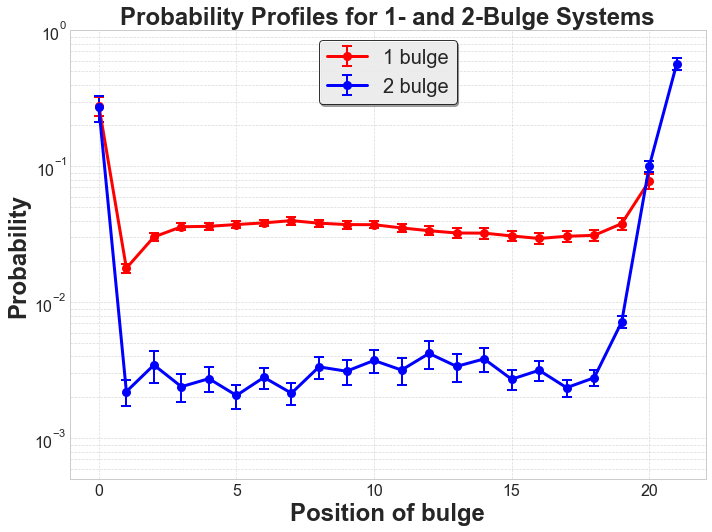

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Saved free energy plot to: final_plots/Free_energy_enhanced.png
Saved free energy plot to: final_plots/Free_energy_enhanced.tiff
Saved free energy plot to: final_plots/Free_energy_enhanced.eps


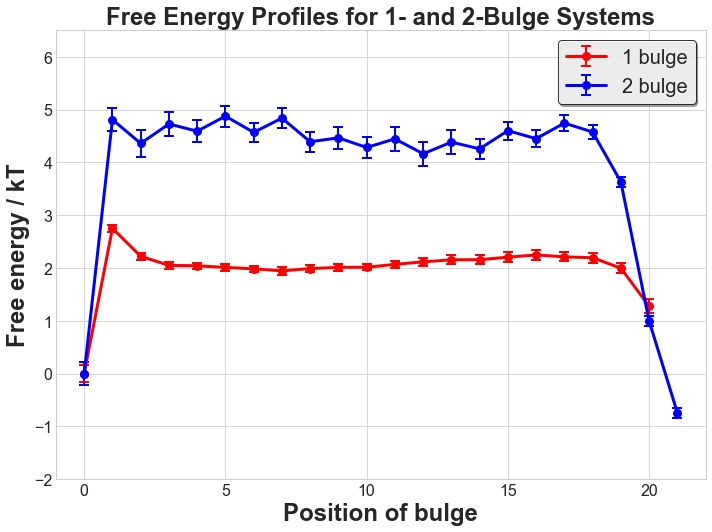


--- Final Analysis and Plotting Complete ---


In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time

# --- Global Parameters ---
# These can be adjusted as needed.
NUM_SIMS = 20
BASE_DATA_DIR = "data"
OUTPUT_DIR = "final_plots"

# --- Analysis Function for 1-Bulge System ---
def analyze_1_bulge_system():
    """
    Analyzes the 1-bulge system data from 20 simulation runs.
    
    Returns:
        tuple: A tuple containing (positions, mean_probabilities, sem_probabilities).
    """
    print("--- Analyzing 1-Bulge System ---")
    
    # Parameters specific to the 1-bulge analysis
    max_len = 23
    folders = [
        "diff_w1", "diff_w1x", "diff_w1x3", "diff_w1x4",
        "diff_w1x5", "diff_w1x6", "diff_w1x7", "diff_w1x8"
    ]
    
    all_op_distributions = []

    for q in range(1, NUM_SIMS + 1):
        tot = np.zeros((max_len, max_len))
        for folder_name in folders:
            file_path = os.path.join(BASE_DATA_DIR, folder_name, f"d_{q}", "energy.dat")
            try:
                # Columns 7, 9, 10 from Mathematica -> 0-indexed 6, 8, 9
                datax = np.loadtxt(file_path, usecols=(6, 8, 9))
                if datax.ndim == 1: datax = datax.reshape(1, -1)
                
                for row in datax:
                    op1, op2, weight = int(row[0]), int(row[1]), 1.0 / row[2]
                    if 0 <= op1 < max_len and 0 <= op2 < max_len:
                        tot[op1, op2] += weight
            except (FileNotFoundError, ValueError):
                pass # Silently skip missing files as in previous logic

        if np.sum(tot) > 0:
            op_distribution = np.sum(tot, axis=0) # Project onto OP2 axis
            op_distribution_trimmed = op_distribution[:-2]
            op_normalized = op_distribution_trimmed / np.sum(tot)
            all_op_distributions.append(op_normalized)

    if not all_op_distributions:
        print("Error: No data found for the 1-bulge system.")
        return None

    prob_array = np.array(all_op_distributions)
    mean_prob = np.mean(prob_array, axis=0)
    std_dev_prob = np.std(prob_array, axis=0, ddof=1)
    sem_prob = std_dev_prob / np.sqrt(len(all_op_distributions))
    positions = np.arange(len(mean_prob))
    
    return positions, mean_prob, sem_prob


# --- Analysis Function for 2-Bulge System (from previous step) ---
def analyze_2_bulge_system():
    """
    Analyzes the 2-bulge system data using WHAM across 20 runs.
    
    Returns:
        tuple: A tuple containing (positions, mean_probabilities, sem_probabilities).
    """
    print("\n--- Analyzing 2-Bulge System (WHAM) ---")
    
    # Parameters specific to the 2-bulge analysis
    DIMS = (35, 22, 22, 2)
    wham_output_dir = "wham_analysis_output"
    
    try:
        data1_all_runs = np.load(os.path.join(wham_output_dir, "preprocessed_data_window1.npy"), allow_pickle=True)
        data2_all_runs = np.load(os.path.join(wham_output_dir, "preprocessed_data_window2.npy"), allow_pickle=True)
        data3_all_runs = np.load(os.path.join(wham_output_dir, "preprocessed_data_window3.npy"), allow_pickle=True)

        weight_dir = os.path.join(BASE_DATA_DIR, '4strand_2kink')
        weights1_raw = np.loadtxt(os.path.join(weight_dir, "wfile_middle_noend.txt"))
        weights2_raw = np.loadtxt(os.path.join(weight_dir, "wfile_startov.txt"))
        weights3_raw = np.loadtxt(os.path.join(weight_dir, "wfile_endov.txt"))
    except FileNotFoundError as e:
        print(f"Error: Could not find required pre-processed or weight files. {e}")
        print("Please ensure you have run the Part 1 pre-processing script first.")
        return None

    w1, w2, w3 = np.zeros(DIMS), np.zeros(DIMS), np.zeros(DIMS)
    for w_raw, w_target in [(weights1_raw, w1), (weights2_raw, w2), (weights3_raw, w3)]:
        for row in w_raw:
            idx = tuple(row[:4].astype(int))
            if all(d < DIMS[i] for i, d in enumerate(idx)):
                w_target[idx] = row[4]

    all_final_prob_profiles = []
    for sim_idx in range(NUM_SIMS):
        data1, data2, data3 = data1_all_runs[sim_idx], data2_all_runs[sim_idx], data3_all_runs[sim_idx]
        if data1 is None or data2 is None or data3 is None:
            continue
            
        s1, s2, s3 = len(data1), len(data2), len(data3)
        aa1, aa2, aa3 = np.zeros(DIMS), np.zeros(DIMS), np.zeros(DIMS)
        for data_list, aa_target in [(data1, aa1), (data2, aa2), (data3, aa3)]:
            for row in data_list:
                idx = tuple(row[:4].astype(int))
                if all(d < DIMS[i] for i, d in enumerate(idx)):
                    aa_target[idx] += 1
        
        F = np.array([1.0, 1.0, 1.0])
        for i in range(100):
            numerator = aa1 + aa2 + aa3
            denominator = (s1 * F[0] * w1) + (s2 * F[1] * w2) + (s3 * F[2] * w3)
            ub = numerator / (denominator + 1e-12)
            S1, S2, S3 = np.sum(w1 * ub), np.sum(w2 * ub), np.sum(w3 * ub)
            F_new = np.array([1/(S1 + 1e-12), 1/(S2 + 1e-12), 1/(S3 + 1e-12)])
            if np.allclose(F, F_new, rtol=1e-6): break
            F = F_new
            
        op1_index = 34
        ub_slice = ub[op1_index, :, :, :]
        count = np.sum(ub_slice, axis=(0, 2))
        if np.sum(count) > 0:
            all_final_prob_profiles.append(count / np.sum(count))

    if not all_final_prob_profiles:
        print("Error: No 2-bulge data could be processed.")
        return None
        
    prob_array = np.array(all_final_prob_profiles)
    mean_prob = np.mean(prob_array, axis=0)
    std_dev_prob = np.std(prob_array, axis=0, ddof=1)
    sem_prob = std_dev_prob / np.sqrt(len(all_final_prob_profiles))
    positions = np.arange(len(mean_prob))
    
    return positions, mean_prob, sem_prob


# --- Final Plotting Function ---
def create_final_plots(data_1bulge, data_2bulge):
    """
    Takes the analysis results from both systems and generates the
    final comparison plots for probability and free energy with enhanced aesthetics.
    """
    if data_1bulge is None or data_2bulge is None:
        print("\nCannot generate plots due to missing data from one or both analyses.")
        return
        
    print("\n--- Part 3: Generating Final Plots ---")
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    # Use a professional plot style
    plt.style.use('seaborn-whitegrid')

    pos1, prob1, err1 = data_1bulge
    pos2, prob2, err2 = data_2bulge
    
    # --- 1. Probability Plot ---
    # Increased figure height for better layout
    fig1, ax1 = plt.subplots(figsize=(10, 7.5)) 
    
    # Plot 1-bulge data with styled error bars
    ax1.errorbar(pos1, prob1, yerr=err1, fmt='-o', color='red', linewidth=3,
                 label='1 bulge', capsize=5, elinewidth=2, markeredgewidth=2, markersize=7)
    
    # Plot 2-bulge data with styled error bars
    ax1.errorbar(pos2, prob2, yerr=err2, fmt='-o', color='blue', linewidth=3,
                 label='2 bulge', capsize=5, elinewidth=2, markeredgewidth=2, markersize=7)
    
    ax1.set_yscale('log')
    ax1.set_xlabel("Position of bulge", fontsize=24, weight='bold')
    ax1.set_ylabel("Probability", fontsize=24, weight='bold')
    ax1.tick_params(axis='both', which='major', labelsize=16)
        
    ax1.set_ylim(5e-4, 1)
    # Moved legend to a clearer position
    ax1.legend(loc='upper center', fontsize=20, frameon=True, edgecolor='black', shadow=True, framealpha=0.8)
    ax1.set_title("Probability Profiles for 1- and 2-Bulge Systems", fontsize=24, weight='bold')
    ax1.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
    fig1.tight_layout()

    # Save the probability plot
    for ext in ['png', 'tiff', 'eps']:
        save_path = os.path.join(OUTPUT_DIR, f"Prob_enhanced.{ext}")
        fig1.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved probability plot to: {save_path}")
    plt.show()

    # --- 2. Free Energy Plot ---
    prob1[prob1 == 0] = 1e-12 # Avoid log(0)
    prob2[prob2 == 0] = 1e-12

    fe1_norm = -np.log(prob1)
    fe1_norm -= fe1_norm[0]
    err_fe1 = err1 / prob1
    
    fe2_norm = -np.log(prob2)
    fe2_norm -= fe2_norm[0]
    err_fe2 = err2 / prob2

    fig2, ax2 = plt.subplots(figsize=(10, 7.5))
    
    # Plot 1-bulge free energy with styled error bars
    ax2.errorbar(pos1, fe1_norm, yerr=err_fe1, fmt='-o', color='red', linewidth=3,
                 label='1 bulge', capsize=5, elinewidth=2, markeredgewidth=2, markersize=7)
    
    # Plot 2-bulge free energy with styled error bars
    ax2.errorbar(pos2, fe2_norm, yerr=err_fe2, fmt='-o', color='blue', linewidth=3,
                 label='2 bulge', capsize=5, elinewidth=2, markeredgewidth=2, markersize=7)

    ax2.set_xlabel("Position of bulge", fontsize=24, weight='bold')
    ax2.set_ylabel("Free energy / kT", fontsize=24, weight='bold')
    ax2.tick_params(axis='both', which='major', labelsize=16)
        
    ax2.set_xlim(-1, 22)
    ax2.set_ylim(-2, 6.5)
    ax2.legend(loc='upper right', fontsize=20, frameon=True, edgecolor='black', shadow=True, framealpha=0.8)
    ax2.set_title("Free Energy Profiles for 1- and 2-Bulge Systems", fontsize=24, weight='bold')
    fig2.tight_layout()

    # Save the free energy plot
    for ext in ['png', 'tiff', 'eps']:
        save_path = os.path.join(OUTPUT_DIR, f"Free_energy_enhanced.{ext}")
        fig2.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved free energy plot to: {save_path}")
    plt.show()


if __name__ == '__main__':
    # Step 1: Analyze the 1-bulge system
    results_1_bulge = analyze_1_bulge_system()
    
    # Step 2: Analyze the 2-bulge system
    results_2_bulge = analyze_2_bulge_system()
    
    # Step 3: Generate the final combined plots
    create_final_plots(results_1_bulge, results_2_bulge)
    
    print("\n--- Final Analysis and Plotting Complete ---")



In [31]:
import os
import numpy as np

def check_simulation_timesteps(base_dir="data", num_sims=20):
    """
    Analyzes 'energy.dat' files to find the final simulation timestep
    for each run in the 1-bulge and 2-bulge systems. This script helps
    verify the total simulation length mentioned in the manuscript.

    It performs the following steps:
    1.  Identifies the folder lists for both the 1-bulge and 2-bulge systems.
    2.  For each system, it iterates through all 20 simulation runs (d_1 to d_20).
    3.  For each run, it inspects all associated 'energy.dat' files. This is
        important because a single simulation run might have its output
        split across multiple directories (common in umbrella sampling).
    4.  It extracts the maximum value from the first column (the timestep) for each run.
    5.  It prints the final timestep for each individual run.
    6.  Finally, it calculates and prints a summary for each system, including
        the average final timestep and the sum, as you requested.

    Args:
        base_dir (str): The main directory containing all simulation folders.
        num_sims (int): The number of independent simulation runs (e.g., 20).
    """

    # --- Define folder structures for both systems ---

    # 1-Bulge System Folders
    folders_1_bulge = [
        "diff_w1", "diff_w1x", "diff_w1x3", "diff_w1x4",
        "diff_w1x5", "diff_w1x6", "diff_w1x7", "diff_w1x8"
    ]

    # 2-Bulge System Folders (all combined)
    folders_2_bulge_middle = ["diff_w3_middle_noendx2", "diff_w3_middle_noendx3", "diff_w3_middle_noendx4"]
    folders_2_bulge_start = ["diff_w3_startov", "diff_w3_startovx2", "diff_w3_startovx3"]
    folders_2_bulge_end = ["diff_w3_endov", "diff_w3_endovx", "diff_w3_endovx2", "diff_w3_endovx3"]
    folders_2_bulge = folders_2_bulge_middle + folders_2_bulge_start + folders_2_bulge_end

    # Dictionary to hold the configurations for both systems
    systems = {
        "1-Bulge System": folders_1_bulge,
        "2-Bulge System": folders_2_bulge
    }

    print("--- Starting Timestep Analysis ---")

    # --- Iterate over each system ---
    for system_name, folders in systems.items():
        print(f"\n=============================================")
        print(f"        Analyzing: {system_name}")
        print(f"=============================================")
        
        final_timesteps_for_system = []

        # --- Loop over each simulation run (d_1 to d_20) ---
        for i in range(1, num_sims + 1):
            max_timestep_for_run = 0
            
            # --- For each run, check all its constituent folders ---
            for folder_name in folders:
                file_path = os.path.join(base_dir, folder_name, f"d_{i}", "energy.dat")

                if os.path.exists(file_path):
                    try:
                        # Read only the first column (timesteps) for efficiency
                        timesteps = np.loadtxt(file_path, usecols=(0,))
                        
                        # Check if the file is not empty and get the max value
                        if timesteps.size > 0:
                            current_max = np.max(timesteps)
                            if current_max > max_timestep_for_run:
                                max_timestep_for_run = current_max
                    except Exception as e:
                        print(f"Warning: Could not process file {file_path}. Error: {e}")

            if max_timestep_for_run > 0:
                final_timesteps_for_system.append(max_timestep_for_run)
                # Print the result for the individual run
                print(f"  Run d_{i:02d}: Final Timestep = {max_timestep_for_run:.2e}")
            else:
                print(f"  Run d_{i:02d}: No 'energy.dat' files found.")

        # --- Summarize results for the entire system ---
        if final_timesteps_for_system:
            final_timesteps_arr = np.array(final_timesteps_for_system)
            total_sum = np.sum(final_timesteps_arr)
            average_timestep = np.mean(final_timesteps_arr)
            std_dev = np.std(final_timesteps_arr)
            
            print("\n  --- System Summary ---")
            print(f"    - Average Final Timestep: {average_timestep:.3e}")
            print(f"    - Standard Deviation:     {std_dev:.3e}")
            print(f"    - Sum of Final Timesteps: {total_sum:.3e} (This is the sum of max timesteps from all 20 runs)")
            
            # Check if values are consistent and close to 1e9
            if np.allclose(final_timesteps_arr, 1e9, rtol=0.01):
                print("\n  Confirmation: All runs are consistent and successfully reached the target of 1e9 steps.")
            else:
                print("\n  Warning: Some runs deviate significantly from the target of 1e9 steps. Please review the list above.")

    print("\n\n--- Analysis Complete ---")


if __name__ == '__main__':
    # This script assumes it is run from a directory that contains
    # the 'data' folder, as per the specified directory structure.
    data_directory = "data"
    
    if not os.path.isdir(data_directory):
        print(f"Error: The '{data_directory}' directory was not found.")
        print("Please ensure you run this script from the correct project folder.")
    else:
        check_simulation_timesteps(base_dir=data_directory)


--- Starting Timestep Analysis ---

        Analyzing: 1-Bulge System
  Run d_01: Final Timestep = 2.90e+07
  Run d_02: Final Timestep = 2.52e+07
  Run d_03: Final Timestep = 2.45e+07
  Run d_04: Final Timestep = 2.59e+07
  Run d_05: Final Timestep = 2.95e+07
  Run d_06: Final Timestep = 2.83e+07
  Run d_07: Final Timestep = 2.77e+07
  Run d_08: Final Timestep = 2.87e+07
  Run d_09: Final Timestep = 2.79e+07
  Run d_10: Final Timestep = 2.85e+07
  Run d_11: Final Timestep = 2.54e+07
  Run d_12: Final Timestep = 2.48e+07
  Run d_13: Final Timestep = 2.50e+07
  Run d_14: Final Timestep = 2.60e+07
  Run d_15: Final Timestep = 2.52e+07
  Run d_16: Final Timestep = 2.51e+07
  Run d_17: Final Timestep = 2.50e+07
  Run d_18: Final Timestep = 2.47e+07
  Run d_19: Final Timestep = 2.43e+07
  Run d_20: Final Timestep = 2.44e+07

  --- System Summary ---
    - Average Final Timestep: 2.625e+07
    - Standard Deviation:     1.745e+06
    - Sum of Final Timesteps: 5.251e+08 (This is the sum of max 